In [1]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.8 MB/s eta 0:00:00


In [2]:
import torch

In [3]:
torch.cuda.is_available()


True

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import matplotlib as plt
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from sklearn.metrics import *
import numpy as np
import pandas as pd
from sklearn.metrics import matthews_corrcoef

In [23]:
X_train = pd.read_csv("X_train.csv")

In [24]:
X_train = X_train.drop('Unnamed: 0', axis=1)

In [25]:
X_train

,Tweet
0,this place capoeira classe evry thursday pm do...
1,after a year and half going back at it legday ...
2,bookwithal all hair styles include sew ins qui...
3,just one of those basic castle pics disneys ma...
4,happy rd birthday to my biggest blessing shair...
...,...
312068,gampn breakfast king
312069,happy as can be las vegas nevad
312070,brought that axe home proud to be a farmer bot...
312071,in my favorite texan city with one of my favor...


In [5]:
X_test = pd.read_csv("X_test.csv")

In [6]:
X_test = X_test.drop('Unnamed: 0', axis=1)

In [7]:
X_test

,Tweet
0,anna hopiefirst day of nd grade kindestlittlegirl
1,taking some time to mention our little unmenti...
2,evlyn seco
3,allcity dncinphl truthopwer we out her spring ...
4,i wish we wer in the same car yesterday saints...
...,...
34670,good weeknd with great friends labordayweeknd ...
34671,once agin netflix amp chill sundaybumday at ap...
34672,happiness only a bucket awy all you got ta do ...
34673,extra special being her tonight with my niec g...


In [8]:
Y_train = pd.read_csv("Y_train.csv")

In [9]:
Y_train = Y_train.drop('Unnamed: 0', axis=1)

In [10]:
Y_train

,0
0,0
1,6
2,13
3,7
4,1
...,...
312068,4
312069,0
312070,13
312071,6


In [11]:
Y_test = pd.read_csv("Y_test.csv")

In [12]:
Y_test = Y_test.drop('Unnamed: 0', axis=1)

In [13]:
Y_test

,0
0,1
1,0
2,13
3,11
4,2
...,...
34670,0
34671,16
34672,14
34673,5


In [89]:
predictions = pd.read_csv("predictions.csv")

In [90]:
predictions = predictions.drop('Unnamed: 0', axis=1)

In [16]:
predictions.tail(30)

,0
34645,1
34646,1
34647,1
34648,0
34649,1
34650,0
34651,0
34652,1
34653,1
34654,1


In [17]:
Y_train = Y_train['0'].values

In [18]:
Y_train

array([ 0,  6, 13, ..., 13,  6,  6])

In [19]:
Y_test = Y_test['0'].values

In [20]:
Y_test

array([ 1,  0, 13, ..., 14,  5, 17])

In [91]:
predictions = predictions['0'].values

In [92]:
predictions

array([0, 1, 1, ..., 1, 0, 1])

In [ ]:
# Transform target in tensors


In [26]:
train_labels = torch.tensor(Y_train[Y_train != 0])

In [27]:

test_labels = torch.tensor(Y_test[predictions != 0])

In [28]:
Y_train.shape

(312073,)

In [29]:
train_labels.shape

torch.Size([245237])

Text Preprocessing for Bert:
#   (1) Tokenize the sentence.
#   (2) Prepend the `[CLS]` token to the start. 
#   (3) Append the `[SEP]` token to the end.
#   (4) Map tokens to their IDs.
#   (5) Pad or truncate the sentence to `max_length`
#   (6) Create attention masks for [PAD] tokens.
Function tokenizer.encode_plus was used which encapsulates the whole procedure

In [30]:
# Load the BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [31]:
X_train.values[0]

array(['this place capoeira classe evry thursday pm dont miss out phytnycgym phytnyc'],
      dtype=object)

In [32]:
# Example for a tweet
print("Tokenized tweet: ", tokenizer.tokenize(X_train.Tweet.values[0]))
print("Original tweet: ", X_train.Tweet.values[0])

Tokenized tweet:  ['this', 'place', 'cap', '##oe', '##ira', 'class', '##e', 'ev', '##ry', 'thursday', 'pm', 'don', '##t', 'miss', 'out', 'ph', '##yt', '##ny', '##c', '##gy', '##m', 'ph', '##yt', '##ny', '##c']
Original tweet:  this place capoeira classe evry thursday pm dont miss out phytnycgym phytnyc


In [33]:
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(X_train.Tweet.values[0])))

Token IDs:  [2023, 2173, 6178, 8913, 7895, 2465, 2063, 23408, 2854, 9432, 7610, 2123, 2102, 3335, 2041, 6887, 22123, 4890, 2278, 6292, 2213, 6887, 22123, 4890, 2278]


In [34]:
# Example complete:
sentence = X_train.Tweet.values[0]
tokens_ = tokenizer.tokenize(sentence)
tokens_ = ['[CLS]'] + tokens_ + ['[SEP]']
print("Tokenized tweet: ", tokens_)
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokens_))



Tokenized tweet:  ['[CLS]', 'this', 'place', 'cap', '##oe', '##ira', 'class', '##e', 'ev', '##ry', 'thursday', 'pm', 'don', '##t', 'miss', 'out', 'ph', '##yt', '##ny', '##c', '##gy', '##m', 'ph', '##yt', '##ny', '##c', '[SEP]']
Token IDs:  [101, 2023, 2173, 6178, 8913, 7895, 2465, 2063, 23408, 2854, 9432, 7610, 2123, 2102, 3335, 2041, 6887, 22123, 4890, 2278, 6292, 2213, 6887, 22123, 4890, 2278, 102]


In [35]:
X_train = X_train.Tweet.astype(str)
X_test = X_test.Tweet.astype(str)

In [36]:
X_train

0         this place capoeira classe evry thursday pm do...
1         after a year and half going back at it legday ...
2         bookwithal all hair styles include sew ins qui...
3         just one of those basic castle pics disneys ma...
4         happy rd birthday to my biggest blessing shair...
                                ...                        
312068                                 gampn breakfast king
312069                      happy as can be las vegas nevad
312070    brought that axe home proud to be a farmer bot...
312071    in my favorite texan city with one of my favor...
312072                       its friday bonmercy beauty bar
Name: Tweet, Length: 312073, dtype: object

Find MAX_LENGTH

In [37]:
train = [len(i.split()) for i in X_train]
test = [len(i.split()) for i in X_test]

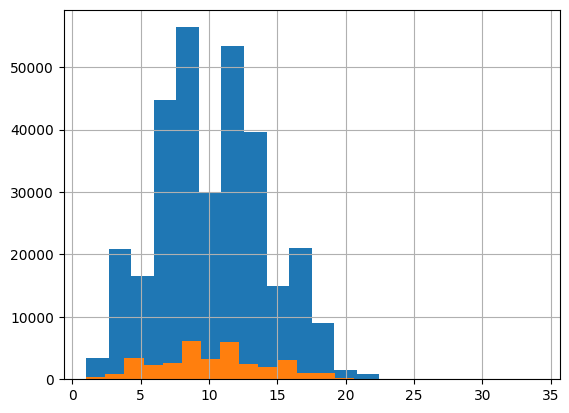

In [38]:
for i in [train, test]:
    pd.Series(i).hist(bins=20)

In [39]:
MAX_LENGTH = 25

In [40]:
def prepare_data(data, max_len):
    inputs_ = []
    attention_mask = []
    for tweet in data:
        encoded_dict = tokenizer.encode_plus(
          tweet, #tweet to encode = (tokenize + add special character)
          add_special_tokens = True, # Add [CLS] for specify classification task and [SEP]
          max_length = max_len,
          pad_to_max_length  = True, #For pad & truncate all sentence
          return_attention_mask = True, # For return attention masks
          #return_tensors = 'pt' # Return pythorch tensors
        )
        # Select encoded sentence    
        inputs_.append(encoded_dict['input_ids'])

        # Select attention masks
        attention_mask.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.tensor(inputs_)
    attention_masks = torch.tensor(attention_mask)

    return input_ids, attention_masks

In [41]:
X_train.shape

(312073,)

In [42]:
X_train, Y_train

(0         this place capoeira classe evry thursday pm do...
 1         after a year and half going back at it legday ...
 2         bookwithal all hair styles include sew ins qui...
 3         just one of those basic castle pics disneys ma...
 4         happy rd birthday to my biggest blessing shair...
                                 ...                        
 312068                                 gampn breakfast king
 312069                      happy as can be las vegas nevad
 312070    brought that axe home proud to be a farmer bot...
 312071    in my favorite texan city with one of my favor...
 312072                       its friday bonmercy beauty bar
 Name: Tweet, Length: 312073, dtype: object,
 array([ 0,  6, 13, ..., 13,  6,  6]))

In [43]:
train_data, train_masks = prepare_data(X_train[Y_train != 0], MAX_LENGTH)
test_data, test_masks = prepare_data(X_test[predictions != 0], MAX_LENGTH)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
train_data.shape

torch.Size([245237, 25])

In [45]:
test_labels.shape

torch.Size([28461])

In [46]:
# Print sentence 0, now as a list of IDs.
print('Original: ', X_train.values[0])
print('Token IDs:', train_data[0])
print('Attention Mask:', train_masks[0])

Original:  this place capoeira classe evry thursday pm dont miss out phytnycgym phytnyc
Token IDs: tensor([  101,  2044,  1037,  2095,  1998,  2431,  2183,  2067,  2012,  2009,
         4190, 10259, 27090, 27090,  7292,  2474,  8873, 27401,  2524,  6198,
          102,     0,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0])


In [47]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(train_data, train_labels,
                                                     random_state=42,
                                                     test_size=0.2)
(train_masks, validation_masks,
 _, _) = train_test_split(train_masks, train_data,
                          random_state=42, test_size=0.2)

In [48]:

train_labels.shape

torch.Size([196189])

In [49]:
train_labels

tensor([5, 8, 9,  ..., 4, 1, 8])

In [50]:
BATCH_SIZE = 32

In [51]:
def dataloader(input_ids, attention_masks, labels, name):
    dataset = TensorDataset(input_ids, attention_masks, labels) #Combine inputs in to a TensorDataset
    if name == "Train":
        sampler = RandomSampler(dataset)  # Select batches randomly
    else:
        sampler = SequentialSampler(dataset)  # Select batches sequentially
    data_loader = DataLoader(
            dataset,
            sampler = sampler,
            batch_size = BATCH_SIZE # Number of batchsize
    )
    print(f"{name} documents {len(dataset)}")
    return data_loader

In [52]:
test_labels

tensor([ 0, 13, 11,  ..., 16, 14, 17])

In [53]:
train_labels.shape

torch.Size([196189])

In [54]:
train_dataloader = dataloader(train_inputs, train_masks, train_labels, "Train")
test_dataloader = dataloader(test_data, test_masks, test_labels, "Test")
val_dataloader = dataloader(validation_inputs, validation_masks, validation_labels, "Validation")
#%90 - %10 (train-test)
#%80 - %20 (asıl train -val)

Train documents 196189
Test documents 28461
Validation documents 49048


In [55]:
# Function to calculate the accuracy of our predictions vs labels
def accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
"bert-base-uncased" = the 12-layer BERT model, with an uncased vocab.se the 12-layer BERT model, with an uncased vocabulary

In [56]:
BERTMODEL = "bert-base-uncased"

In [57]:
#0 mı başka bir emoji mi
model = BertForSequenceClassification.from_pretrained(
    BERTMODEL, 
    num_labels = 20, # Binary classification   
    output_attentions = False, 
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [58]:
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [59]:
# Optimizasyon ayarları
optimizer = AdamW(model.parameters(),
                  lr=2e-5,
                  eps=1e-8
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [60]:
epochs = 3
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [61]:
# Tell PyTorch to use the GPU.    
device = torch.device("cuda")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [62]:
training_stats = []
for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device) #batch[0] - input_ids
        b_input_mask = batch[1].to(device) #batch[1] - attention_masks
        b_labels = batch[2].to(device) #batch[2] - labels

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs".
        model.zero_grad() 

        # Forward pass (for evaluate the model on this training batch)
        model1 = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels) 
        loss = model1.loss
        logits = model1.logits
        
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()       


        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)    

    print("\n \t Average training loss: {0:.4f}".format(avg_train_loss))
    
    
    # ========================================
    #               Validation PHASE 
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model2 = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss = model2.loss
            logits = model2.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    print("  Accuracy: {0:.4f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    print("  Validation Loss: {0:.4f}".format(avg_val_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )


======== Epoch 1 / 3 ========
Training...

 	 Average training loss: 2.2843
  Accuracy: 0.3588
  Validation Loss: 2.1358

======== Epoch 2 / 3 ========
Training...

 	 Average training loss: 2.0297
  Accuracy: 0.3664
  Validation Loss: 2.1056

======== Epoch 3 / 3 ========
Training...

 	 Average training loss: 1.8625
  Accuracy: 0.3653
  Validation Loss: 2.1398


In [71]:
# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions2 , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
    with torch.no_grad():
      # Forward pass, calculate logit predictions
       outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]

  # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    prediction = np.argmax(logits, axis=1)

  # Store predictions and true labels
    for i in prediction:
        predictions2.append(i)
    for i in label_ids:
        true_labels.append(i)

In [72]:
def model_evaluation(real_v, pred_v):
    print(f"Accuracy sore: {accuracy_score(real_v, pred_v)}")
    print("Classification report:")
    print(classification_report(real_v, pred_v))
    cm = confusion_matrix(real_v, pred_v)
    print (f"Confusion matrix \n {cm}")
    return cm

In [73]:
cm = model_evaluation(true_labels, predictions2)

Accuracy sore: 0.3116896806155792
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4603
           1       0.26      0.53      0.35      3019
           2       0.41      0.64      0.50      3449
           3       0.18      0.27      0.22      1287
           4       0.49      0.56      0.52      1734
           5       0.15      0.18      0.17      1411
           6       0.17      0.15      0.16      1433
           7       0.26      0.31      0.28      1093
           8       0.22      0.16      0.19       843
           9       0.18      0.21      0.19       898
          10       0.28      0.34      0.31      1087
          11       0.55      0.65      0.60       982
          12       0.35      0.56      0.43       851
          13       0.35      0.06      0.11       624
          14       0.14      0.09      0.11       886
          15       0.27      0.22      0.25       892
          16       0.14 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


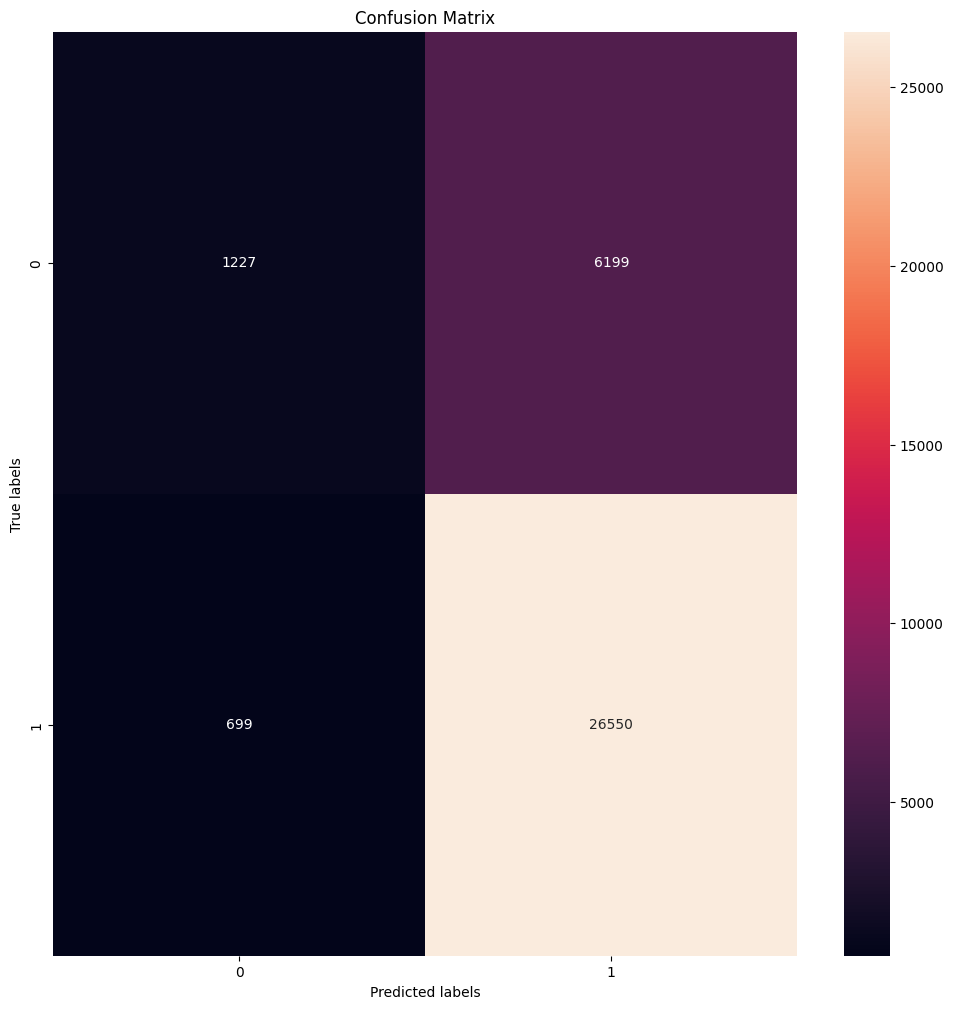

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Büyük boyutlu bir figür oluşturun
plt.figure(figsize=(12, 12))

# Isı haritasını çizin
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [84]:
len(predictions2)

28461

In [ ]:
predictions

In [93]:
last_predict = []
j = 0
for i in range(0, len(predictions)):
  if predictions[i] == 0:
    last_predict.append(predictions[i])
  else:
    last_predict.append(predictions2[j])
    j = j+1


In [95]:
cm = model_evaluation(Y_test, last_predict)

Accuracy sore: 0.3372458543619322
Classification report:
              precision    recall  f1-score   support

           0       0.45      0.38      0.41      7426
           1       0.26      0.44      0.32      3670
           2       0.41      0.60      0.49      3640
           3       0.18      0.20      0.19      1787
           4       0.49      0.53      0.51      1819
           5       0.15      0.16      0.15      1660
           6       0.17      0.14      0.15      1548
           7       0.26      0.27      0.26      1238
           8       0.22      0.12      0.16      1128
           9       0.18      0.16      0.17      1144
          10       0.28      0.32      0.29      1171
          11       0.55      0.61      0.58      1054
          12       0.35      0.51      0.42       933
          13       0.35      0.05      0.08       882
          14       0.14      0.08      0.10       954
          15       0.27      0.21      0.23       974
          16       0.14 

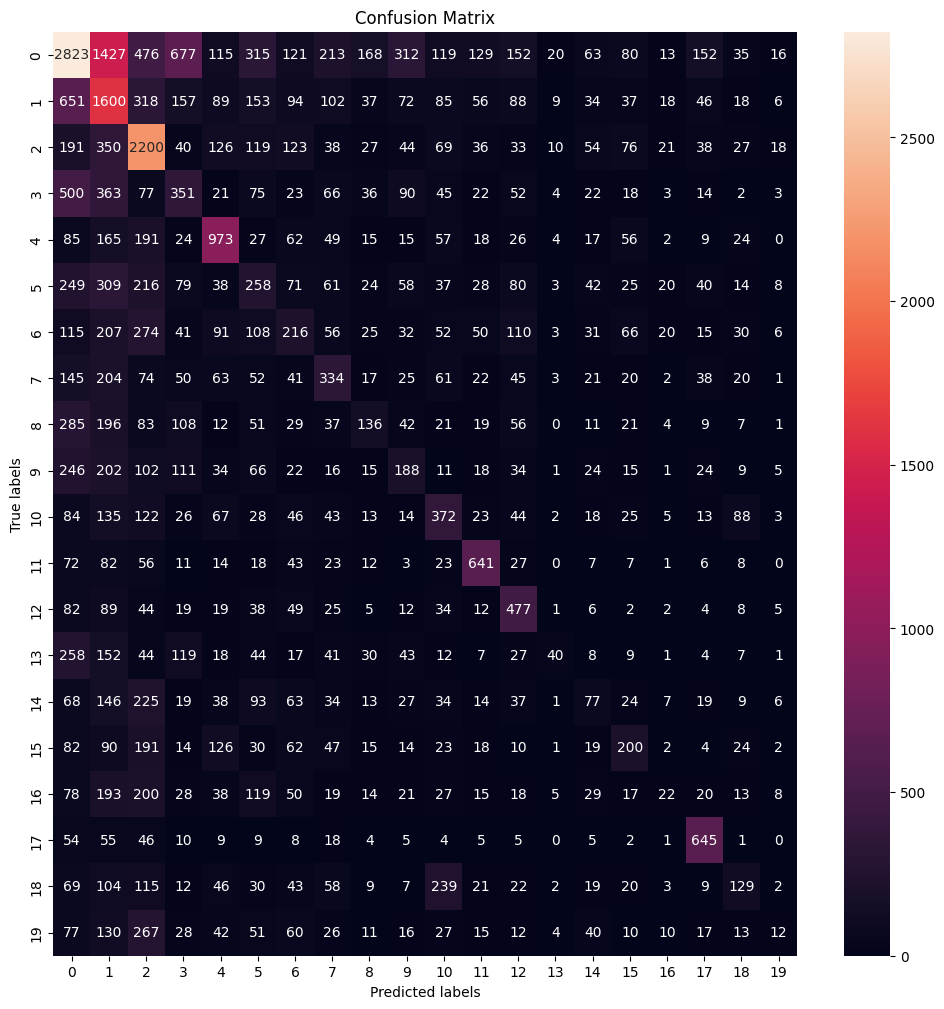

In [97]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Büyük boyutlu bir figür oluşturun
plt.figure(figsize=(12, 12))

# Isı haritasını çizin
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 